## Overfit

Accuracy of the model would peak after training for a number of epochs and would then stagnate or start decreasing. This happens when model learn patterns in the training data that don't generalize the test data.

## Underfit

Occurs when theres still room for improvement on the test data. This can happen for number of reasons:
- Model is too simple
- Over-regularization
- Not trained long enough
This means the network has not learned the relevant patterns in the training data.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers, regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import pathlib
import shutil
import tempfile

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)

In [3]:
# get higgs boson data

gz = tf.keras.utils.get_file(
    "HIGGS.csv.gz", 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
)

```tf.data.experimental.CsvDataset``` class can be used to read csv records directly from gzip file with no intermediate decompression set.
This csv reader returns a list of scalars for each record.

In [4]:
FEATURES = 28

ds = tf.data.experimental.CsvDataset(
    gz,
    [float(),] * (FEATURES + 1), 
    compression_type="GZIP"
)

Create a function to repacks dataset list of scalars into feature-vector and label pair.

In [5]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

Make new dataset that take batches of 10000 examples, apply ```pack_row``` function to each batch and split into individual records.

In [6]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


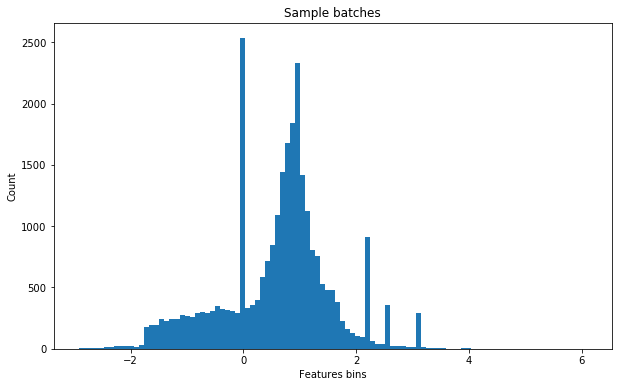

In [7]:
plt.figure(figsize = (10, 6))
plt.xlabel("Features bins")
plt.ylabel("Count")
plt.title("Sample batches")
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [8]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE # division and floor

In [9]:
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
validate_ds = packed_ds.take(N_VALIDATION).cache()

In [10]:
# use batch method to create batches of an appropriate size of
# training
# shuffle and repeat the training set before batching

train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
validate_ds = validate_ds.batch(BATCH_SIZE)

Sets ```schedules.InverseTimeDecay``` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

In [11]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH * 1000,
    decay_rate = 1,
    staircase = False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

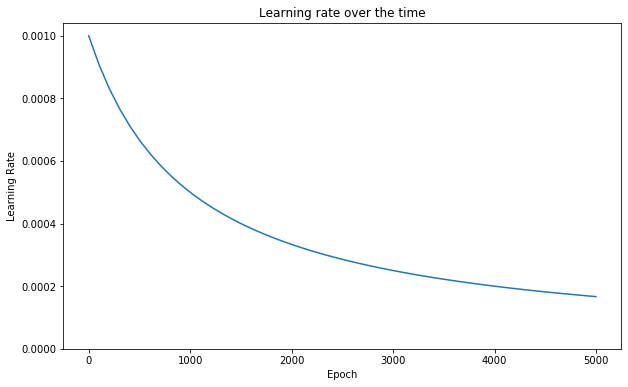

In [12]:
# inverse time decay visualisation

step = np.linspace(0, 100000)
lr = lr_schedule(step)

plt.figure(figsize = (10, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning rate over the time")
plt.show()

## Training configuration

When using same training configuration repeatedly, these configurations can be made reusable as a callbacks.

```tfdocs.EpochDots``` will be used to reduce the logging noise since these training runs for many short epochs. This will perform dot operation on every epoch and a full set of metrics every 100 epochs.

```callbacks.EarlyStopping``` to avoid long and unnecessary training times. This callback will be set to monitor the output of the loss function : ```val_binary_crossentropy``` instead of the metric ```val_loss```.

```callbacks.TensorBoard``` will be used to generate TensorBoard logs for the training.

In [13]:


def get_callbacks(model_name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(
            monitor = "val_binary_crossentropy",
            patience = 200
        ),
        tf.keras.callbacks.TensorBoard(logdir/model_name)
    ]

def compile_and_fit(model, name, optimizer = None, max_epochs = 10000):
    if optimizer is None:
        optimizer = get_optimizer()
        
    model.compile(
        optimizer = optimizer,
        loss = "binary_crossentropy",
        metrics = [
            "accuracy",
            "binary_crossentropy"
        ]
    )
    
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose = 0
    )
    
    return history

In [14]:
from tensorflow.keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + "D:/Program Files (x86)/Graphviz2.38/bin/"
size_histories = {}

## Model - tiny

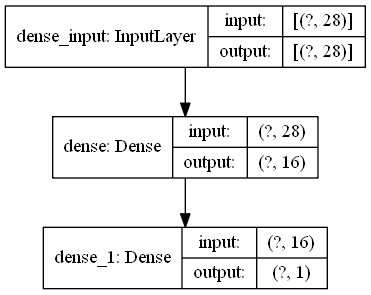

In [15]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation = "relu", input_shape = (FEATURES,)),
    layers.Dense(1, activation = "sigmoid")
])

plot_model(
    tiny_model,
    show_shapes = True,
    expand_nested = True
)

In [16]:
size_histories["tiny"] = compile_and_fit(tiny_model, "sizes/tiny")


Epoch: 0, accuracy:0.5179,  binary_crossentropy:0.7230,  loss:0.7230,  val_accuracy:0.5410,  val_binary_crossentropy:0.7004,  val_loss:0.7004,  
....................................................................................................
Epoch: 100, accuracy:0.6638,  binary_crossentropy:0.6128,  loss:0.6128,  val_accuracy:0.6420,  val_binary_crossentropy:0.6255,  val_loss:0.6255,  
....................................................................................................
Epoch: 200, accuracy:0.6824,  binary_crossentropy:0.5970,  loss:0.5970,  val_accuracy:0.6550,  val_binary_crossentropy:0.6116,  val_loss:0.6116,  
....................................................................................................
Epoch: 300, accuracy:0.6972,  binary_crossentropy:0.5836,  loss:0.5836,  val_accuracy:0.6750,  val_binary_crossentropy:0.5971,  val_loss:0.5971,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

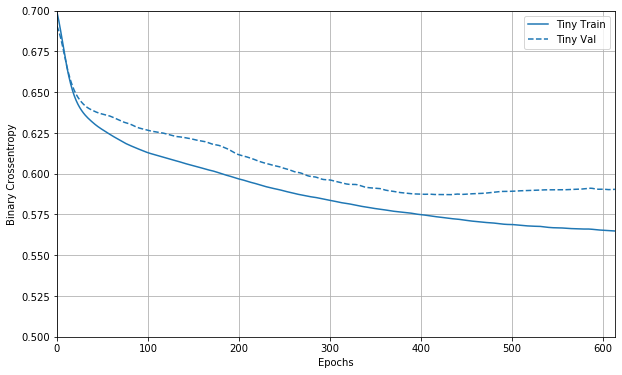

In [17]:
plt.figure(figsize = (10, 6))
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'binary_crossentropy', 
    smoothing_std=10
)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## Small model

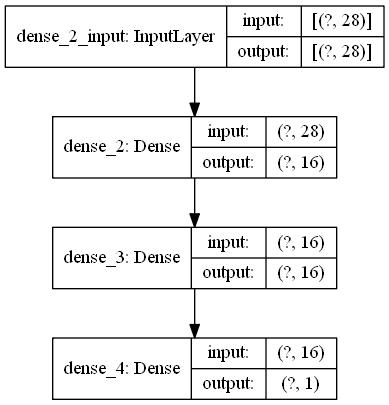

In [18]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

plot_model(
    small_model,
    show_shapes = True,
    expand_nested = True
)

In [19]:
size_histories['small'] = compile_and_fit(small_model, 'sizes/small')


Epoch: 0, accuracy:0.5018,  binary_crossentropy:0.7354,  loss:0.7354,  val_accuracy:0.4840,  val_binary_crossentropy:0.7175,  val_loss:0.7175,  
....................................................................................................
Epoch: 100, accuracy:0.6569,  binary_crossentropy:0.6180,  loss:0.6180,  val_accuracy:0.6520,  val_binary_crossentropy:0.6239,  val_loss:0.6239,  
....................................................................................................
Epoch: 200, accuracy:0.6795,  binary_crossentropy:0.5939,  loss:0.5939,  val_accuracy:0.6770,  val_binary_crossentropy:0.6018,  val_loss:0.6018,  
....................................................................................................
Epoch: 300, accuracy:0.6980,  binary_crossentropy:0.5766,  loss:0.5766,  val_accuracy:0.6800,  val_binary_crossentropy:0.5924,  val_loss:0.5924,  
....................................................................................................
Epoch: 40

## Medium model

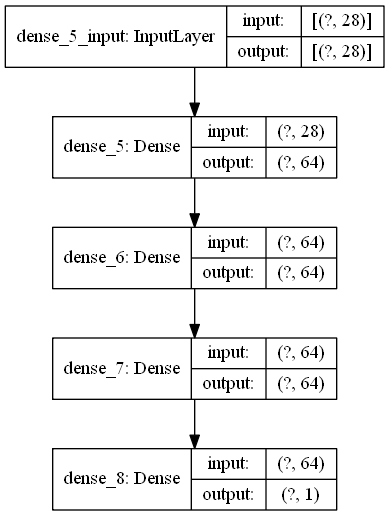

In [20]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

plot_model(
    medium_model,
    show_shapes = True,
    expand_nested = True
)

In [21]:
size_histories['medium']  = compile_and_fit(medium_model, "sizes/medium")


Epoch: 0, accuracy:0.5168,  binary_crossentropy:0.7036,  loss:0.7036,  val_accuracy:0.5420,  val_binary_crossentropy:0.6851,  val_loss:0.6851,  
....................................................................................................
Epoch: 100, accuracy:0.7372,  binary_crossentropy:0.5262,  loss:0.5262,  val_accuracy:0.6680,  val_binary_crossentropy:0.6166,  val_loss:0.6166,  
....................................................................................................
Epoch: 200, accuracy:0.8007,  binary_crossentropy:0.4329,  loss:0.4329,  val_accuracy:0.6450,  val_binary_crossentropy:0.7024,  val_loss:0.7024,  
...........................................................

## Large model

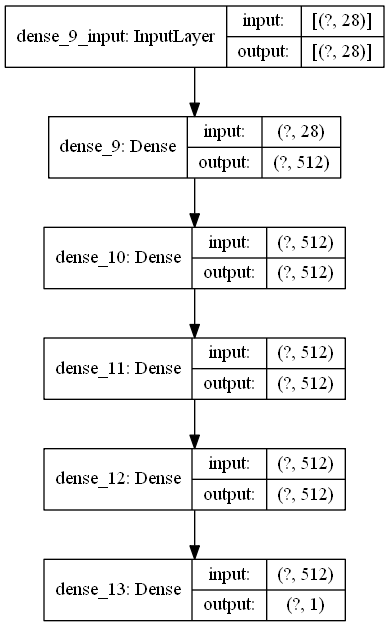

In [22]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

plot_model(
    large_model,
    show_shapes = True,
    expand_nested = True
)

In [23]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Epoch: 0, accuracy:0.5316,  binary_crossentropy:0.7800,  loss:0.7800,  val_accuracy:0.5580,  val_binary_crossentropy:0.6816,  val_loss:0.6816,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0022,  loss:0.0022,  val_accuracy:0.6740,  val_binary_crossentropy:1.7984,  val_loss:1.7984,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6760,  val_binary_crossentropy:2.4443,  val_loss:2.4443,  
.............................

## Training and validation loss of models

- solid lines show the training loss
- dashed lines show the validation loss (a lower vaidation loss indicates a better model)

While building a larger model gives it more power, it can easily overfit the training dataset. From these results, only ```tiny``` model manages overfitting altogether and each of the larger models overfit more quickly.

This is apparent when comparing the training and validation metrics.
- If both metrics are moving in the same direction, everything is fine.
- If the validation metric begin to stagnate while the training metric continues to improve, its close to overfitting.
- If the validation metric is going in the wrong direction, its overfitting. 

(0.5, 0.7)

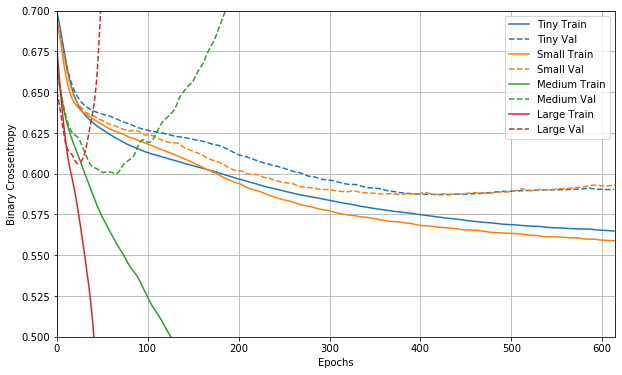

In [24]:
plt.figure(figsize = (10, 6))
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'binary_crossentropy', 
    smoothing_std=10
)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

(0.5, 0.7)

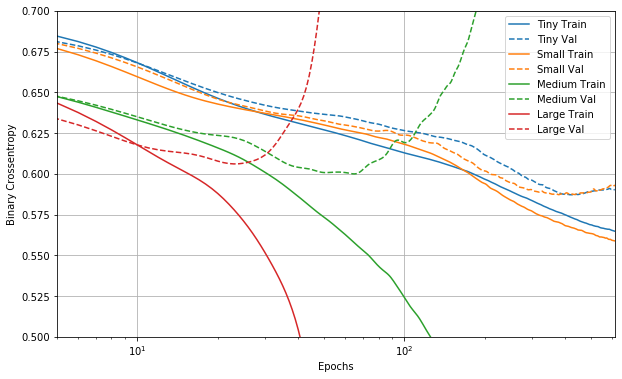

In [25]:
# log scale view to check on the performance of medium and large model

plt.figure(figsize = (10, 6))
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'binary_crossentropy', 
    smoothing_std=10
)
plotter.plot(size_histories)
plt.xscale("log")
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])

## Tensorboard view

These models are all written to TensorBoard logs during training.

In [27]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
%tensorboard --logdir {logdir}

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9728.